In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
num_steps = 3001
num_states = 25

In [3]:
gamma = 0.4

In [4]:
reload = True

# Functions and Params

In [5]:
def run_models():
    data = {}
    print_every_steps = 50

    lr_exps = [-0.5, -1, -1.5]
    cmap = cm.get_cmap('Greens', len(lr_exps)+4)
    for idx, lr_exp in enumerate(lr_exps):
        lr = 10**lr_exp
        linear = Linear(num_states, lr=lr, gamma=gamma)
        key = 'FF-TD $\eta=10^{' + str(lr_exp) + '}$'
        data[key] = {}
        data[key]['color'] = cmap(idx + 2)
        data[key]['t_errors'] = []
        data[key]['m_errors'] = []
        data[key]['row_norm'] = []
        data[key]['steps'] = []
        t_errs, m_errs, row_norms, _ = eval(
            linear, datasets, print_every_steps=print_every_steps
            )
        for t_err, m_err, row_norm in zip(t_errs, m_errs, row_norms):
            data[key]['t_errors'].extend(t_err.tolist())
            data[key]['m_errors'].extend(m_err.tolist())
            data[key]['row_norm'].extend(row_norm.tolist())
            data[key]['steps'].extend(range(print_every_steps, num_steps, print_every_steps))

    lr_exps = [-1, -1.5, -2]
    cmap = cm.get_cmap('Oranges', len(lr_exps)+2)
    for idx, lr_exp in enumerate(lr_exps):
        lr = 10**lr_exp
        net = STDP_SR(2, gamma, ca3_kwargs={'static_eta': lr})
        key = 'RNN-S, Static $\eta=10^{' + str(lr_exp) + '}$'
        data[key] = {}
        data[key]['color'] = cmap(idx + 2)
        data[key]['t_errors'] = []
        data[key]['m_errors'] = []
        data[key]['row_norm'] = []
        data[key]['steps'] = []
        t_errs, m_errs, row_norms, _ = eval(
            net, datasets, print_every_steps=print_every_steps
            )
        for t_err, m_err, row_norm in zip(t_errs, m_errs, row_norms):
            data[key]['t_errors'].extend(t_err.tolist())
            data[key]['m_errors'].extend(m_err.tolist())
            data[key]['row_norm'].extend(row_norm.tolist())
            data[key]['steps'].extend(range(print_every_steps, num_steps, print_every_steps))

    net = STDP_SR(2, gamma)
    t_error, m_error, row_norm, _ = eval(
        net, datasets
        )
    key = f'RNN-S, Adaptive $\eta$'
    data[key] = {}
    data[key]['color'] = 'C0'
    data[key]['t_errors'] = []
    data[key]['m_errors'] = []
    data[key]['row_norm'] = []
    data[key]['steps'] = []
    t_errs, m_errs, row_norms, _ = eval(
        net, datasets, print_every_steps=print_every_steps
        )
    for t_err, m_err, row_norm in zip(t_errs, m_errs, row_norms):
        data[key]['t_errors'].extend(t_err.tolist())
        data[key]['m_errors'].extend(m_err.tolist())
        data[key]['row_norm'].extend(row_norm.tolist())
        data[key]['steps'].extend(range(print_every_steps, num_steps, print_every_steps))

    return data

# Unbiased Walk

In [24]:
prob_dists = [[1,1,1]]
p_file = 'pickles/2de_sr_model_comparisons_unbiased.p'

iters = 15
datasets = []
for _ in range(iters):
    for p_dist in prob_dists:
        datasets.append(inputs.Sim1DWalk(
            num_steps=num_steps, num_states=num_states,
            left_right_stay_prob=p_dist
            ))

In [25]:
if reload:
    with open(p_file, 'rb') as f:
        data = pickle.load(f)
else:
    data = run_models()
    with open(p_file, 'wb') as f:
        pickle.dump(data, f)

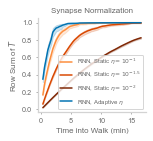

In [26]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'TD' in key: continue
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['row_norm'],
        color=_data['color'], label=key, ax=ax#, legend=False
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('Row Sum of $T$')
plt.title('Synapse Normalization')
plt.tight_layout()
plt.savefig('../figures/S2a.png', dpi=300, transparent=True)
plt.show()

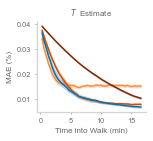

In [27]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'TD' in key: continue
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['t_errors'],
        color=_data['color'], label=key, ax=ax, legend=None
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE (%)')
plt.title('$T$  Estimate')
plt.tight_layout()
plt.savefig('../figures/S2b.png', dpi=300, transparent=True)
plt.show()

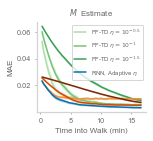

In [28]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'Static' in key:
        label = None
    else:
        label = key
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['m_errors'],
        color=_data['color'], label=label, ax=ax
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE')
plt.title('$M$  Estimate')
plt.tight_layout()
plt.savefig('../figures/S2c.png', dpi=300, transparent=True)
plt.show()

# Stay biased walk

In [6]:
num_steps=10000
reload = False

In [7]:
prob_dists = [[1,1,5]]
p_file = 'pickles/2de_sr_model_comparisons_staybiased.p'

iters = 5
datasets = []
for _ in range(iters):
    for p_dist in prob_dists:
        datasets.append(inputs.Sim1DWalk(
            num_steps=num_steps, num_states=num_states,
            left_right_stay_prob=p_dist
            ))

In [ ]:
if reload:
    with open(p_file, 'rb') as f:
        data = pickle.load(f)
else:
    data = run_models()
    with open(p_file, 'wb') as f:
        pickle.dump(data, f)

In [ ]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'TD' in key: continue
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['row_norm'],
        color=_data['color'], label=key, ax=ax#, legend=False
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('Row Sum of $T$')
plt.title('Synapse Normalization')
plt.tight_layout()
plt.savefig('../figures/S2d.png', dpi=300, transparent=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'TD' in key: continue
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['t_errors'],
        color=_data['color'], label=key, ax=ax, legend=None
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE (%)')
plt.title('$T$  Estimate')
plt.tight_layout()
plt.savefig('../figures/S2e.png', dpi=300, transparent=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.5/3, 2.))
for key in data.keys():
    if 'Static' in key:
        label = None
    else:
        label = key
    _data = data[key]
    steps = _data['steps']
    steps = [s/configs.dt_to_sec/60 for s in steps]
    sns.lineplot(
        x=steps, y=_data['m_errors'],
        color=_data['color'], label=label, ax=ax
        )
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE')
plt.title('$M$  Estimate')
plt.tight_layout()
plt.savefig('../figures/S2f.png', dpi=300, transparent=True)
plt.show()